# MonkeyGrad.. Like MicroGrad/TinyGrad but built by a monkey

### Note
This code is inspired by Andrej Karpathy's video series on youtube. https://github.com/karpathy/micrograd <br> After watching the video once I am attempting to recreate the code from memory. Hopefully I can turn it into something usable as a fun project.<br><br>- Aryan M

In [455]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MLUtils import loadingAnimation, printPurple, plot_function, displayPower
import random

In [456]:
# Value class
class Value:
    """
    Value class that stores a single scalar value and its gradient, also added functions to be able to add/multiply objects.
    
    Attributes:
        value (float): The value of the object
        grad (float): The gradient of the object
        _prev (set): The set of all the previous objects
        _operation (str): The operation that was used to get the value
        _backward (function): The function that is used to back propagate the gradient
        
    Operations:
        __add__: Adds two values together
        __mul__: Multiplies two values together
        __truediv__: Divides two values together
        __pow__: Raises a value to a power
        __neg__: Negates a value

    Back Propagation:
        backProp: Back propagates the gradient through the graph
    
    Activation Functions:
        relu: Applies the ReLU activation function
        tanh: Applies the Tanh activation function
        sigmoid: Applies the Sigmoid activation function
        
    Repr: 
        Returns Value({label}: Data: {value}, Grad: {grad})
    """
    
    def __init__(self, value, _children=(), _op = "", **kwargs):
        self.label = kwargs["label"] if "label" in kwargs else ""
        self.value = value
        self.grad = random.uniform(-1, 1)
        self._prev = set(_children)
        self._operation = _op
        self._backward = lambda: None
        
    # Arithmatic Operations
        
    def __add__(self, other) -> "Value":
        other = other if isinstance(other, Value) else Value(other) # checks if it is a value at first and if not, it creates a value
        out = Value(self.value + other.value, (self, other), "+")   # adds just the values of the Value data types
        
        def backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = backward
        
        return out
    
    def __mul__(self, other) -> "Value":
        other = other if isinstance(other, Value) else Value(other) # checks if it is a value at first and if not, it creates a value
        out = Value(self.value * other.value, (self, other), "*")
        
        def backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = backward
        return out
    
    def __truediv__(self, other) -> "Value":
        return self.__mul__(other**-1)
    
    def __pow__(self, other) -> "Value":
        assert isinstance(other, (int, float)), "Power must be a number"
        out = Value(self.value**other, (self,), displayPower(self.label if self.label != "" else "(" + str(round(self.value, 6)) + ")", other.label if isinstance(other, Value) and other.label != "" else str(other)))
        
        def backward():
            self.grad += (other * self.value**(other-1)) * out.grad
        out._backward = backward
        
        return out
    
    def __round__(self, other) -> "Value":
        return Value(self.value.__round__(other))
    
    def __neg__(self):
        return self * -1
    
    # Reverse Arithmatic Operations
        
    def __radd__(self, other) -> "Value":
        return self.__add__(other)
    
    def __rmul__(self, other) -> "Value":
        return self.__mul__(other)
    
    def __rtruediv__(self, other) -> "Value":
        return self.__truediv__(other)
    
    def __rpow__(self, other) -> "Value":
        return self.__pow__(other)
    
    # Activation Functions
        
    def relu(self) -> "Value":
        out = Value(0 if self.value < 0 else self.value, (self,), "ReLU")
        
        def backward():
            self.grad += (out.value > 0) * out.grad
        out._backward = backward
        
        return out
    
    def tanh(self) -> "Value":
        out = Value(np.tanh(self.value), (self,), "Tanh")
        
        def backward():
            self.grad += (1 - out.value**2) * out.grad
        out._backward = backward
        
        return out
    
    def sigmoid(self) -> "Value":
        out = Value(1/(1+np.exp(-self.value)), (self,), "Sigmoid")
        
        def backward():
            self.grad += out.value * (1 - out.value) * out.grad
        out._backward = backward
        
        return out
        
    # Back Propagation
    
    def backProp(self) -> None: 
        topo = []
        visited = set()
        def build_topo(v):  # Dont really understand the topo map but need to dive into it further
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __repr__(self):
        return f'Value({self.label + ": " if self.label != "" else self.label}Data: {self.value}, Grad: {self.grad})' # Didnt even know you could add functions like that but glad I tried it

In [457]:
from graphviz import Digraph, render

class Visualizer():
    def __init__(self, root, rankdir = 'LR'):
        self.root = root
        self.nodes, self.edges = self.trace()
        self.format = 'pdf'
        self.rankdir = rankdir
    
    def trace(self):
            nodes, edges = set(), set()
            
            def build(current):
                if current not in nodes:
                    nodes.add(current)
                    for child in current._prev:
                        edges.add((child, current))
                        build(child)
            build(self.root)
            
            return nodes, edges
    
    def __call__(self, output = False):
        drawing = Digraph(format=self.format)
        drawing.attr(rankdir=self.rankdir)  # Set the rankdir attribute here
        
        for node in self.nodes:
            uid = str(id(node))
            label = "{%s | data %.4f | grad %.4f}" % (node.label, node.value, node.grad)
            drawing.node(name=uid, label=label, shape='record')
            
            if node._operation:
                drawing.node(name=uid + node._operation, label=node._operation)
                drawing.edge(uid + node._operation, uid)
                    
        for node1, node2 in self.edges:
            drawing.edge(str(id(node1)), str(id(node2)) + node2._operation)
            
        return drawing

In [458]:
class Neuron:
    '''
    A class to represent a neuron in a neural network.
    
    Attributes:
        weights (list): A list of weights for each input.
        bias (float): A bias value.
        activation (string): The activation function to use.
                Options: 'relu', 'sigmoid', 'tanh'

    '''
    
    def __init__(self, numInp, activation='relu'):
        self.weights = [Value(random.uniform(-1, 1), label = "wi") for i in range(numInp)]
        self.bias = Value(0, label='bias')
        self.activation = activation
        self.inputs = []

    def __call__(self, inputs):
        for i in inputs:
            i = Value(i)
            self.inputs.append(i)
            i.label = 'xi'
            
        wixiTotal = Value(0) ; wixiTotal.label = "wixi"
        for wi, xi in zip(self.weights, inputs):
            wixi = wi * xi ; wixi.label = "wixi"
            wixiTotal += wixi
            wixiTotal.label = "wixi"
        
        total = wixiTotal + self.bias
        total.label = 'total'
        
        if self.activation == 'relu':
            return total.relu()
        elif self.activation == 'sigmoid':
            return total.sigmoid()
        elif self.activation == 'tanh':
            return total.tanh()
        else:
            return total
        
    def parameters(self):
        return self.weights + [self.bias]
    
    def __repr__(self):
        return f'\nInputs: \t{self.inputs} \nWeights: \t{list(map(lambda x: round(x, 4), self.weights))} \nBias: \t\t{[self.bias]}\n'

In [459]:
class Layer:
    def __init__(self, numInput, numNeurons): # numNeurons is the same as specifying the number of outputs
        self.Neurons = [Neuron(numInput) for i in range(numNeurons)]
        
    def __call__(self, x):
        out = [Neuron(x) for Neuron in self.Neurons]
        return out[0] if len(out) == 1 else out # Figuring out Andrej's code here
    
    def parameters(self):
        return [p for n in self.Neurons for p in n.parameters()]
    
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.Neurons)}]"
    
class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def zeroGrad(self):
        for param in self.parameters():
            param.grad = 0

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

## Testing

In [460]:
# initialize a model 
model = MLP(3, [4, 4, 1]) # 2-layer neural network
print(model)

MLP of [Layer of [
Inputs: 	[] 
Weights: 	[Value(Data: 0.8151, Grad: 0.5203491709231693), Value(Data: 0.9787, Grad: -0.08236099266053487), Value(Data: 0.8796, Grad: -0.24157391463207367)] 
Bias: 		[Value(bias: Data: 0, Grad: 0.9689932157246679)]
, 
Inputs: 	[] 
Weights: 	[Value(Data: -0.0025, Grad: -0.419140126435271), Value(Data: -0.7252, Grad: -0.8270719177491024), Value(Data: -0.7394, Grad: -0.7644339905605455)] 
Bias: 		[Value(bias: Data: 0, Grad: 0.932642625499525)]
, 
Inputs: 	[] 
Weights: 	[Value(Data: -0.5349, Grad: 0.8674570718769434), Value(Data: 0.8913, Grad: 0.6505922431272888), Value(Data: 0.2919, Grad: -0.9515633758139745)] 
Bias: 		[Value(bias: Data: 0, Grad: -0.7475669239470939)]
, 
Inputs: 	[] 
Weights: 	[Value(Data: 0.3264, Grad: 0.6999371954673879), Value(Data: -0.2979, Grad: 0.946687223272644), Value(Data: 0.1197, Grad: -0.6865951776755717)] 
Bias: 		[Value(bias: Data: 0, Grad: -0.5474968098064363)]
], Layer of [
Inputs: 	[] 
Weights: 	[Value(Data: -0.5783, Grad: 0.

In [461]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [model(x) for x in xs]
ypred

[Value(Data: 3.29062377407151, Grad: 0.6548887682230653),
 Value(Data: 1.9778592472608572, Grad: 0.1607806334905959),
 Value(Data: 1.9736310823846934, Grad: -0.038833761995843874),
 Value(Data: 0.9189694967569992, Grad: 0.10220998127654424)]

In [462]:
model.zeroGrad()
loss = sum((yOut + (-yGroundTruth)) ** 2 for yGroundTruth, yOut in zip(ys, ypred))
loss.backProp()
loss.label = "Loss"
loss

Value(Loss: Data: 22.963650727418788, Grad: 1)

In [463]:
[(yOut + (-yGroundTruth)) ** 2 for yGroundTruth, yOut in zip(ys, ypred)]    

[Value(Data: 5.246957274341608, Grad: -0.9622125212826282),
 Value(Data: 8.867645696496998, Grad: 0.04384471480664587),
 Value(Data: 8.842481814124364, Grad: 0.23987790851644197),
 Value(Data: 0.006565942455813957, Grad: -0.09739285725755353)]

Value(Loss: Data: 22.963650727418788, Grad: 1)


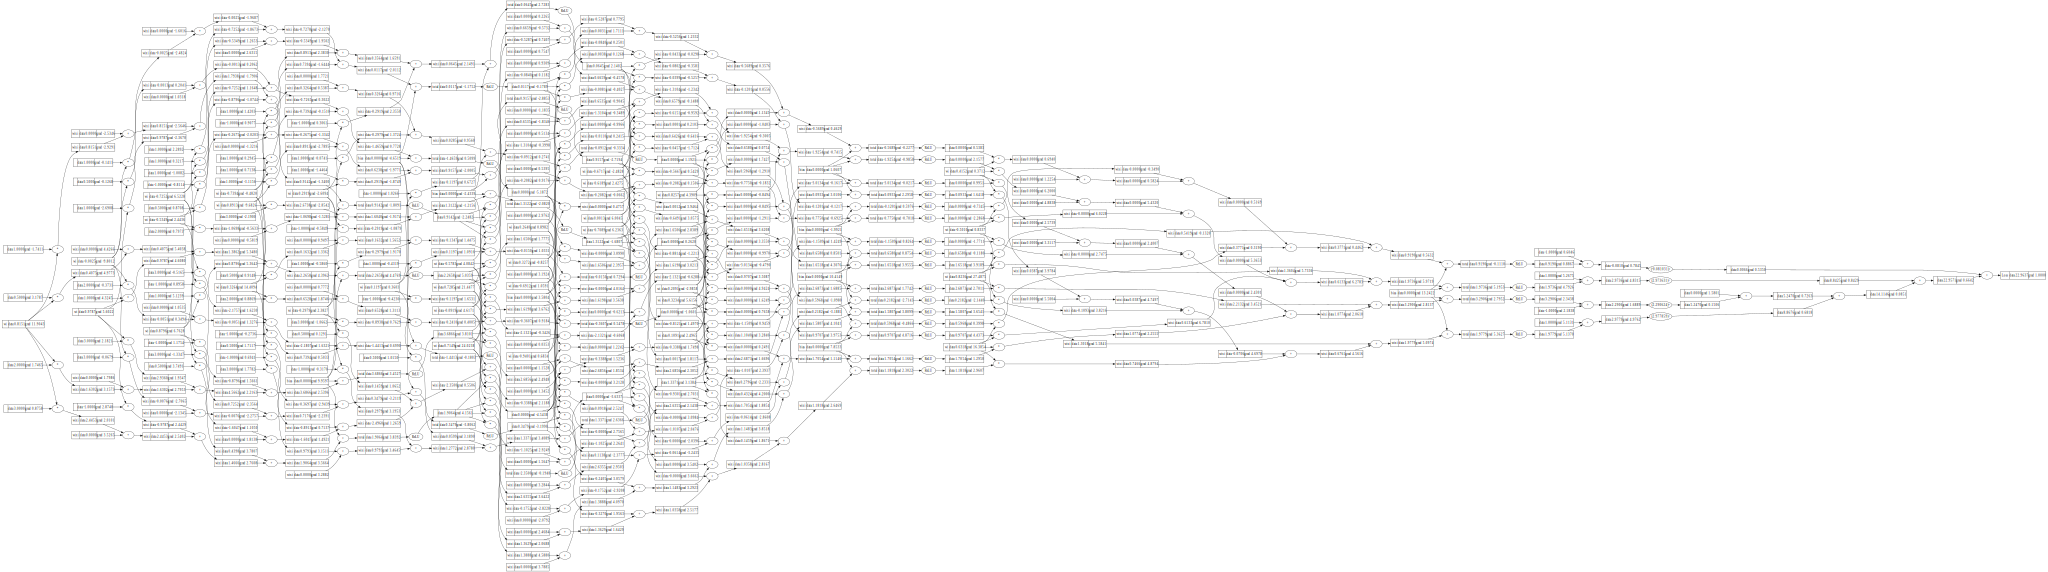

In [464]:
# DONT RUN THIS EVERY TIME IT TAKES A LONG TIME
# Visualize the model
print(loss)
Visualizer(loss)(True)

# Uncomment the above if u want to seet the visualizations

In [465]:
# How to return parameters
print(f'Value Class for the first layer, first neuron:\t\t\t', end = "")
printPurple(model.layers[0].Neurons[0].weights[0])

print(f'Value for the first layer, first neuron, first weight:\t\t', end = "")
printPurple(model.layers[0].Neurons[0].weights[0].value)

print(f'Value for the first layer, first neuron, first Gradient:\t', end = "")
printPurple(f"{model.layers[0].Neurons[0].weights[0].grad} \n")

print("Parameters for the first Neuron, first layer, and the whole model:")
print("Neuron:\t\t", end = "")
printPurple(f"{model.layers[0].Neurons[0].parameters()}")
print("Layer:\t\t", end = "")
printPurple(f"{model.layers[0].parameters()}")
print("Model:\t\t", end = "")
printPurple(f"{model.parameters()}\n")

print("Num Parameters:\t", end = "")

printPurple(f'{len(model.parameters())}')

Value Class for the first layer, first neuron:			Value(wi: Data: 0.8150968555576097, Grad: 11.904278363344787)
Value for the first layer, first neuron, first weight:		0.8150968555576097
Value for the first layer, first neuron, first Gradient:	11.904278363344787 

Parameters for the first Neuron, first layer, and the whole model:
Neuron:		[Value(wi: Data: 0.8150968555576097, Grad: 11.904278363344787), Value(wi: Data: 0.97867907526933, Grad: 5.60215240388695), Value(wi: Data: 0.8795973290227386, Grad: 6.762812958937067), Value(bias: Data: 0, Grad: 9.959656037287209)]
Layer:		[Value(wi: Data: 0.8150968555576097, Grad: 11.904278363344787), Value(wi: Data: 0.97867907526933, Grad: 5.60215240388695), Value(wi: Data: 0.8795973290227386, Grad: 6.762812958937067), Value(bias: Data: 0, Grad: 9.959656037287209), Value(wi: Data: -0.002540842574837443, Grad: -9.801179351271898), Value(wi: Data: -0.725219992326886, Grad: 6.522848704197951), Value(wi: Data: -0.7394176762410754, Grad: -0.48195236391362

In [466]:
epochs = 10
lr = 0.1
for k in range(epochs):

    ypred = [model(x) for x in xs]
    loss = sum((yOut + (-yGroundTruth)) ** 2 for yGroundTruth, yOut in zip(ys, ypred))
    
    for param in model.parameters():
        param.grad = 0.0
    loss.backProp()
    
    for param in model.parameters():
        param.value += (-lr) * param.grad
        
    print (f'Epoch {k+1} Loss: {loss.value:.3f}')
    print([model(x) for x in xs])

Epoch 1 Loss: 22.964
[Value(Data: 0, Grad: 0.050309871746385904), Value(Data: 0, Grad: -0.9396802313475232), Value(Data: 0, Grad: 0.14377867440089043), Value(Data: 0, Grad: -0.9907127629691312)]
Epoch 2 Loss: 4.000
[Value(Data: 0, Grad: -0.12253915778088387), Value(Data: 0, Grad: 0.32880842756316575), Value(Data: 0, Grad: -0.6725213795240124), Value(Data: 0, Grad: 0.6625731046818417)]
Epoch 3 Loss: 4.000
[Value(Data: 0, Grad: -0.3784769663396097), Value(Data: 0, Grad: -0.39852809193123595), Value(Data: 0, Grad: 0.14801356245215702), Value(Data: 0, Grad: -0.23347182661673105)]
Epoch 4 Loss: 4.000
[Value(Data: 0, Grad: 0.0725408012577522), Value(Data: 0, Grad: 0.8030359847342641), Value(Data: 0, Grad: 0.6770806182657434), Value(Data: 0, Grad: -0.20926906463180872)]
Epoch 5 Loss: 4.000
[Value(Data: 0, Grad: 0.5211371711235286), Value(Data: 0, Grad: -0.6669060404298419), Value(Data: 0, Grad: 0.5298446987420207), Value(Data: 0, Grad: -0.4364735914355229)]
Epoch 6 Loss: 4.000
[Value(Data: 83

In [467]:
x = [Value(1.0), Value(-2.0)]   # Input parameters
neuron = Neuron(len(x), 'tanh') # Create a neuron with 2 inputs and tanh activation function
y = neuron(x)                   # Output of the neuron
y.backProp() # Perform backpropagation to calculate the gradients

Neuron: 
Inputs: 	[Value(xi: Data: Value(Data: 1.0, Grad: -0.26414703869522693), Grad: -0.17014390802771628), Value(xi: Data: Value(Data: -2.0, Grad: -0.8687333558318158), Grad: 0.7056673797218413)] 
Weights: 	[Value(Data: -0.5744, Grad: 0.8100024377006025), Value(Data: 0.6262, Grad: 0.4037487465328711)] 
Bias: 		[Value(bias: Data: 0, Grad: 0.3885821937744045)]



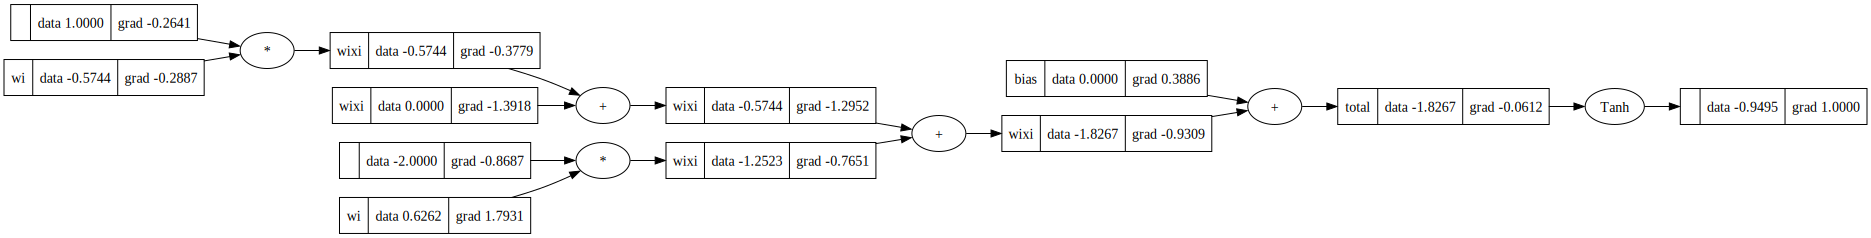

In [468]:

print("Neuron:",neuron)
Visualizer(y)()

In [469]:
printPurple("\nDockstring for Value Class: ")
print(Value.__doc__)                           # added docstring


Dockstring for Value Class: 

    Value class that stores a single scalar value and its gradient, also added functions to be able to add/multiply objects.
    
    Attributes:
        value (float): The value of the object
        grad (float): The gradient of the object
        _prev (set): The set of all the previous objects
        _operation (str): The operation that was used to get the value
        _backward (function): The function that is used to back propagate the gradient
        
    Operations:
        __add__: Adds two values together
        __mul__: Multiplies two values together
        __truediv__: Divides two values together
        __pow__: Raises a value to a power
        __neg__: Negates a value

    Back Propagation:
        backProp: Back propagates the gradient through the graph
    
    Activation Functions:
        relu: Applies the ReLU activation function
        tanh: Applies the Tanh activation function
        sigmoid: Applies the Sigmoid activation fun

In [470]:
# Testing the prototype for the Value class

x = Value(2.0)  ; x.label = 'x'
y = Value(0.38462)  ; y.label = 'y'
j = Value(3.0) ; j.label = 'j'

z = y **2   ; z.label = 'z'
f = ((z + x) / 34)  ; f.label = 'f'
h = f.tanh() ; h.label = 'h'


printPurple(f'\n{z}')
print("z Previous: " , z._prev)
printPurple(f)
print("f Previous: ", f._prev)       
printPurple(h)
print("h Previous: ", h._prev) # Added _prev to track children

printPurple("\nTesting radd and rmul:")
print(2.0 + x, "\t",x + 2.0)                    # Added radd
print(6.0 * x, "\t", x * 6.0)                   # Added rmul

h.backProp() # Dont call backProp far from


Value(z: Data: 0.1479325444, Grad: 0.7561370548512563)
z Previous:  {Value(y: Data: 0.38462, Grad: -0.7609586167375024)}
Value(f: Data: 0.06317448660000001, Grad: -0.5995578374430808)
f Previous:  {Value(Data: 2.1479325444, Grad: -0.2182977490785214), Value(Data: 0.029411764705882353, Grad: 0.26861471493621436)}
Value(h: Data: 0.0630905770939617, Grad: 0.7810272120559145)
h Previous:  {Value(f: Data: 0.06317448660000001, Grad: -0.5995578374430808)}

Testing radd and rmul:
Value(Data: 4.0, Grad: 0.03242304348890834) 	 Value(Data: 4.0, Grad: -0.014261891921231395)
Value(Data: 12.0, Grad: 0.7220940402821634) 	 Value(Data: 12.0, Grad: -0.05845443807843753)


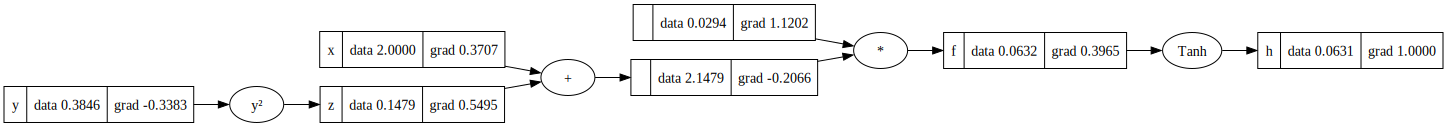

In [471]:
v = Visualizer(h)
v() # I think this can be cleaner but I dont know how at the moment

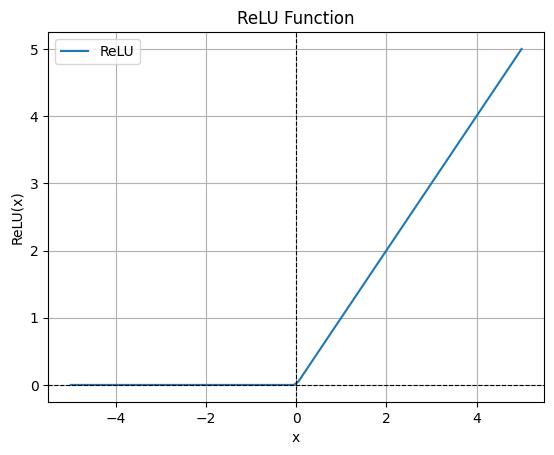

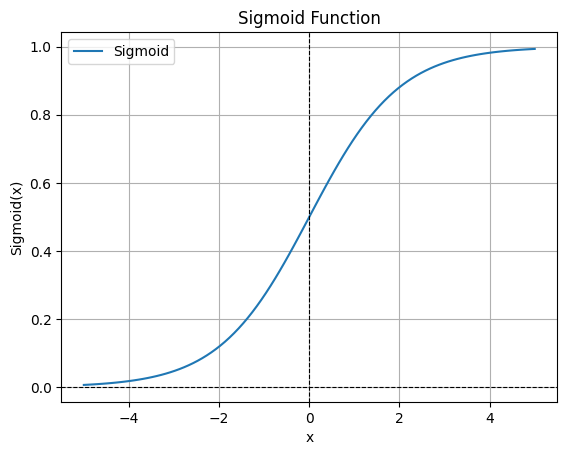

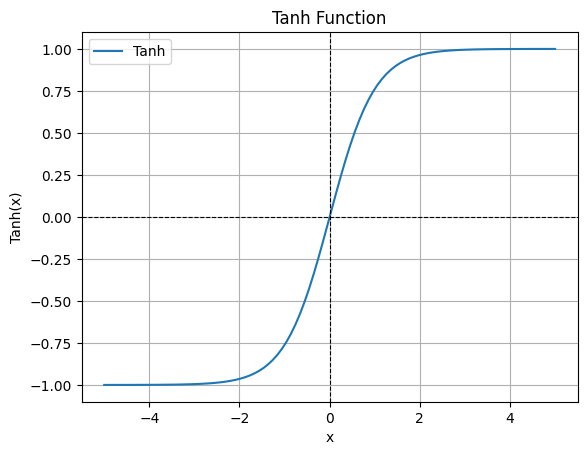

In [472]:
# making a graphical representation of a different activation functions

def printActivationFunctions():
    def relu(x):
        return np.maximum(0, x)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def tanh(x):
        return np.tanh(x)

    plot_function(relu, 'ReLU')
    plot_function(sigmoid, 'Sigmoid')
    plot_function(tanh, 'Tanh')

printActivationFunctions()